In [14]:
import numpy as np

In [15]:
from helpers import clopper_pearson_interval

In [16]:
def moving_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

qp = 0
def plot_stability(file_name, window_size=30, generalize=25, color=None, label=None, axes=None, default_color=False):
    global qp
    responses = np.load(f"test_cache/permute/{file_name}.npz")["finer"][:, :950]
    trials = responses.shape[0]
    train_sum = np.sum(responses, axis=0)
    train_avg = np.average(responses, axis=0)
    lower_bounds = []
    upper_bounds = []

    for val in train_sum:
        l, u = clopper_pearson_interval(val if val != 0 else 1, trials)
        lower_bounds.append(l)
        upper_bounds.append(u)

    marker = None
    if "mean" in label:
        marker = "dotted"
        alpha=1.0
    elif "max" in label:
        marker = "dashed"
        alpha = 1.0
        
    smoothed_train_avg = moving_average(train_avg, window_size)
    smoothed_lower_bounds = moving_average(lower_bounds, window_size)
    smoothed_upper_bounds = moving_average(upper_bounds, window_size)

    if default_color:
        axes.plot(np.array(range(len(smoothed_train_avg)))+generalize, smoothed_train_avg,  linestyle="-", label=label, linewidth=2, color=color)
    
    else:
        if marker is not None:
            axes.plot(np.array(range(len(smoothed_train_avg)))+generalize, smoothed_train_avg, alpha=alpha, linestyle=marker, color=color, label=label, linewidth=2)
            qp += 1
        else:
            axes.plot(np.array(range(len(smoothed_train_avg)))+generalize, smoothed_train_avg,  linestyle="-", color="black", label=label, linewidth=2)

    # if "hyena" in file_name and "max" in file_name:
    #     print(smoothed_lower_bounds, smoothed_upper_bounds)
        
    axes.fill_between(np.array(range(len(smoothed_train_avg)))+generalize, np.clip(smoothed_lower_bounds, 0, 1),
                     np.clip(smoothed_upper_bounds, 0, 1), color='grey', alpha=0.3)

In [17]:
import matplotlib.pyplot as plt

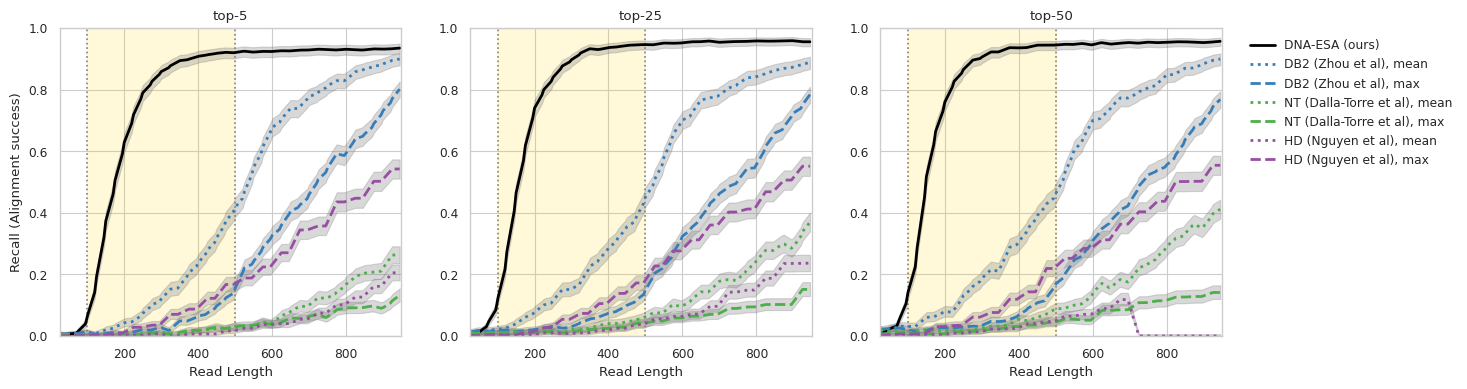

In [18]:
panes = {
    "top-5": {"DNA-ESA": "run_config-trained-all-longer-all_random_sub_1000_5_25", 
              "mean-DNA2BERT": "run_config-dna2bert-mean-all_1000_5_25", 
              "max-DNA2BERT": "run_config-dna2bert-max-all_1000_5_25",
              "mean-NucleotideTransformer": "run_config-nucleotide-transformer-mean-all_1000_5_25",
              "max-NucleotideTransformer": "run_config-nucleotide-transformer-max-all_1000_5_25",
              "mean-HyenaDNA": "run_config-hyena-dna-mean-all_1000_5_50",
              "max-HyenaDNA": "run_config-hyena-dna-max-all_1000_5_50",
    },
    "top-25": {"DNA-ESA": "run_config-trained-all-longer-all_random_sub_1000_25_25", 
              "mean-DNA2BERT": "run_config-dna2bert-mean-all_1000_25_25", 
              "max-DNA2BERT": "run_config-dna2bert-max-all_1000_25_25",
              "mean-NucleotideTransformer": "run_config-nucleotide-transformer-mean-all_1000_25_25",
              "max-NucleotideTransformer": "run_config-nucleotide-transformer-max-all_1000_25_50",
              "mean-HyenaDNA": "run_config-hyena-dna-mean-all_1000_25_50",
              "max-HyenaDNA": "run_config-hyena-dna-max-all_1000_25_50",
    },
    "top-50": {"DNA-ESA": "run_config-trained-all-longer-all_random_sub_1000_50_25", 
              "mean-DNA2BERT": "run_config-dna2bert-mean-all_1000_50_25", 
              "max-DNA2BERT": "run_config-dna2bert-max-all_1000_50_25",
              "mean-NucleotideTransformer": "run_config-nucleotide-transformer-mean-all_1000_50_25",
              "max-NucleotideTransformer": "run_config-nucleotide-transformer-max-all_1000_50_50",
              "mean-HyenaDNA": "run_config-hyena-dna-mean-all_1000_50_50",
              "max-HyenaDNA": "run_config-hyena-dna-max-all_1000_50_50",
    }
}

label_vocabulary = {"DNA-ESA": "DNA-ESA (ours)", "mean-DNA2BERT": "DB2 (Zhou et al), mean", "max-DNA2BERT": "DB2 (Zhou et al), max", 
                    "mean-NucleotideTransformer": "NT (Dalla-Torre et al), mean", "max-NucleotideTransformer": "NT (Dalla-Torre et al), max",
                    "mean-HyenaDNA": "HD (Nguyen et al), mean", "max-HyenaDNA": "HD (Nguyen et al), max"}
import seaborn as sns
colors = sns.color_palette("Set1")

color_dict = {}
for i,(k,pane) in enumerate(panes["top-5"].items()):
    color_dict[k] = colors[(i+1)//2]


csfont = {'fontname':'Times New Roman'}
sns.set_style("whitegrid")
sns.set_context("paper") #, {"grid.color": ".6", "grid.linestyle": ":"})


fig, ax = plt.subplots(1, 3, figsize=(15, 4))       
order = ["top-5", "top-25", "top-50"]
for i, ord_ in enumerate(order):
    ax[i].axvline(x=100, color='gray', linestyle='dotted')
    ax[i].axvline(x=500, color='gray', linestyle='dotted')
    ax[i].fill_between([100, 500], 0, 1, color='gold', alpha=0.15)
    for k,v in panes[ord_].items():
        try:
            plot_stability(panes[ord_][k], color=color_dict[k], label=label_vocabulary[k], axes = ax[i])
        except:
            pass
    ax[i].set_xlabel("Read Length")
    if i == 0:
        ax[i].set_ylabel("Recall (Alignment success)")
    # ax[i].grid(which="both")
    ax[i].set_xlim([25, 950])
    ax[i].set_ylim([0,1])
    ax[i].set_title(ord_)
    # if i == len(order) - 1:  # Only for the last subplot
    #     ax[i].legend(fontsize="8", loc="lower right", bbox_to_anchor=(1, 1))
    # else:
    #     ax[i].legend().set_visible(False)  # Hide legend for other subplots
        
    # ax[i].legend(fontsize="8", loc="upper left")
fig.subplots_adjust(right=0.90)  # Adjust the value as needed

# Create a legend outside the subplots
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, facecolor='white')
# plt.legend()

output_file = 'figures/baselines.png'
plt.savefig(output_file, dpi=500, bbox_inches='tight', format="png")
plt.show()

# remove grey and replace gold

{'top-1': (0.20973515, 0.09747934, 0.24238489), 'top-2': (0.43860848, 0.12177004, 0.34119475), 'top-5': (0.67824099, 0.09192342, 0.3504148), 'top-25': (0.8833417, 0.19830556, 0.26014181), 'top-50': (0.95381595, 0.46373781, 0.31769923)}


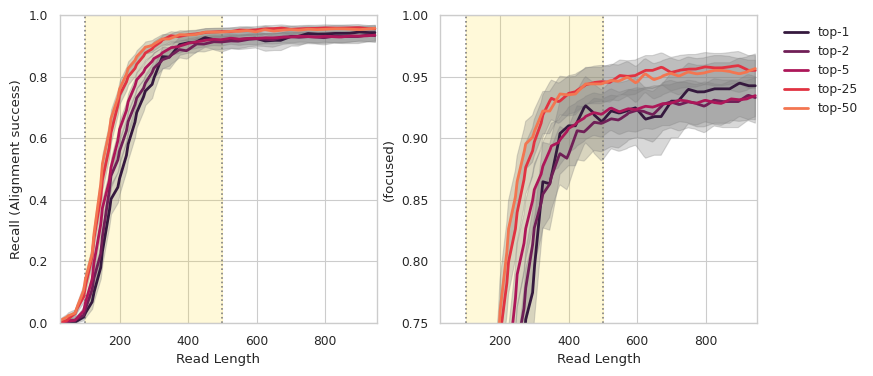

In [25]:
panes = {
    "top-1": "run_config-trained-all-longer-all_random_sub_1000_1_25",
    "top-2": "run_config-trained-all-longer-all_random_sub_1000_2_25",
    "top-5": "run_config-trained-all-longer-all_random_sub_1000_5_25",
    "top-25": "run_config-trained-all-longer-all_random_sub_1000_25_25",
    "top-50": "run_config-trained-all-longer-all_random_sub_1000_50_25"
}

csfont = {'fontname':'Times New Roman'}
colors = sns.color_palette("rocket")
color_dict = {}
for i,(k,pane) in enumerate(panes.items()):
    color_dict[k] = colors[i]
    
print(color_dict)   
fig, ax = plt.subplots(1, 2, figsize=(9, 4))   

order = ["top-1", "top-2", "top-5", "top-25", "top-50"]
for ax_ in ax:

    ax_.axvline(x=100, color='gray', linestyle='dotted')
    ax_.axvline(x=500, color='gray', linestyle='dotted')
    ax_.fill_between([100, 500], 0, 1, color='gold', alpha=0.15)
    
    for i, ord_ in enumerate(order):
        try:
            plot_stability(panes[ord_], label=ord_, axes = ax_, color = color_dict[ord_], default_color=True)
        except:
            pass

ax[0].set_xlabel("Read Length")        
        
ax[0].set_xlim([25,950])
ax[0].set_ylim([0,1])

ax[0].set_ylabel("Recall (Alignment success)")
#ax[0].fill_between([100, 500], 0, 1, color='cyan', alpha=0.1)
# ax[0].legend(fontsize="10", loc="lower right")

ax[1].set_xlabel("Read Length")        
        
ax[1].set_xlim([25,950])
ax[1].set_ylim([0.75,1])
ax[1].set_ylabel("(focused)")

#ax[1].fill_between([100, 500], 0, 1, color='cyan', alpha=0.1)
# ax[1].legend(fontsize="10", loc="lower right")

fig.subplots_adjust(right=0.90)  # Adjust the value as needed

# Create a legend outside the subplots
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, facecolor='white')

output_file = 'figures/topk.png'
plt.savefig(output_file, dpi=500, bbox_inches='tight', format="png")
plt.show()

In [20]:
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [21]:
import pandas as pd
df = pd.read_csv("/home/pholur/dna2vec/evaluate/test_cache/accuracy/table.csv", comment = "#")

In [22]:
df.head()

,Quality,Read length,Insertion rate,Deletion rate,TopK,Distance bound,Exactness,Accuracy
0,(60; 90),250,0.0,0.0,50,50,10,0.9190
1,(60; 90),250,0.0,0.0,50,25,10,0.9066
2,(60; 90),250,0.0,0.0,50,0,10,0.8668
3,(60; 90),250,0.0,0.0,100,50,10,0.9296
4,(60; 90),250,0.0,0.0,100,25,10,0.9188


In [23]:
bars = []
success_rate = 0.971
successes = success_rate * 5000
trials = 5000
vals = clopper_pearson_interval(successes, trials)
print(max(success_rate - vals[0], vals[1] - success_rate))

0.0050350811999985146


In [24]:
df.to_csv("/home/pholur/dna2vec/evaluate/test_cache/accuracy/table_with_bars.csv")